In [1]:
%matplotlib inline
import matplotlib.pyplot as plt      

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam

import hyperparams as hp
from datasets import WaveNetDataset, wav_collate
from visualize import show_spectrogram, show_audio
from audio import wav_to_spectrogram
from text import text_to_sequence, sequence_to_text

In [2]:
x = Variable(torch.rand(1, 1, 9))

In [3]:

class CausalConv1d(nn.Module):
    """
    pads the left side of input sequence just enough so that the convolutional kernel
    does not look into the future.
    
    Input and output sizes will be the same.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation, **kwargs):
        super().__init__()
        pad = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv1(x)
        x = x[:, :, :-self.conv1.padding[0]]  # remove trailing padding
        return x

In [4]:
dataset = WaveNetDataset(path='/home/austin/data/tacotron/LJSpeech-1.0')

In [5]:
S, audio = dataset[0]

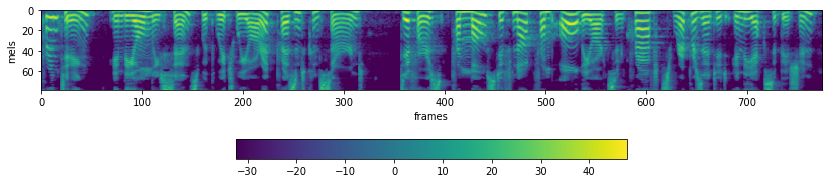

In [6]:
show_spectrogram(S.T)

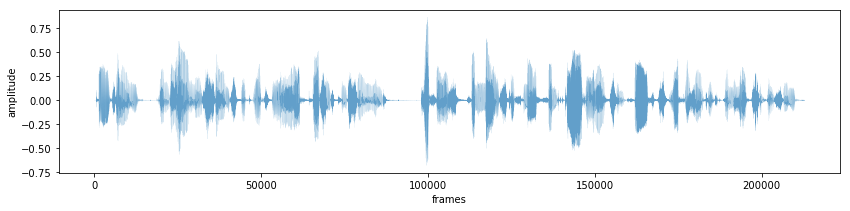

In [7]:
show_audio(audio)

In [8]:
loader = DataLoader(dataset, collate_fn=wav_collate, batch_size=2)

In [9]:
s, a, spec_lens, audio_lens = next(iter(loader))

In [10]:
s


( 0 ,.,.) = 
 -29.1256 -19.3614 -15.1094  ...  -16.9808 -22.6821 -32.3366
 -32.3366 -18.6557 -16.4300  ...  -23.2756 -24.6269 -22.1557
 -24.9015 -15.8297 -12.9641  ...  -17.9327 -17.8955 -21.4484
            ...               ⋱              ...            
 -32.3366 -24.4313 -20.7612  ...  -32.3366 -32.3366 -32.3366
 -32.3366 -18.1103 -14.4647  ...  -32.3366 -32.3366 -32.3366
 -32.3366  -6.1805  -1.2438  ...  -32.3366 -32.3366 -32.3366

( 1 ,.,.) = 
 -16.9468 -14.9690  -6.3278  ...    0.0000   0.0000   0.0000
 -11.7444  -1.3981   1.6303  ...    0.0000   0.0000   0.0000
  -5.4229   2.5186  10.2062  ...    0.0000   0.0000   0.0000
            ...               ⋱              ...            
 -38.9847 -37.4157 -19.0288  ...    0.0000   0.0000   0.0000
 -38.9847 -30.3334 -11.7720  ...    0.0000   0.0000   0.0000
 -38.9847 -24.0026  -6.4049  ...    0.0000   0.0000   0.0000
[torch.FloatTensor of size 2x80x775]

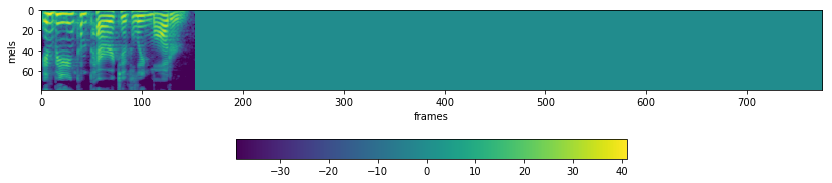

In [11]:
show_spectrogram(s[1])

In [12]:
conv = CausalConv1d(80, 32, kernel_size=2, dilation=1)

In [13]:
conv(Variable(s))

Variable containing:
( 0 ,.,.) = 
  1.2270e+01  1.5641e-01  2.3471e-01  ...   4.9744e+00  2.4117e+00  3.4456e+00
  3.1678e+00 -1.3772e-01 -2.1489e+00  ...  -5.0671e+00 -3.6850e+00 -2.6886e+00
  1.6617e+00 -1.2656e+01 -9.7266e+00  ...  -6.1300e+00 -5.1471e+00 -5.6658e+00
                 ...                   ⋱                   ...                
 -2.3221e+00 -1.4827e+01 -9.1285e+00  ...  -4.4333e+00 -8.3727e+00 -1.0696e+01
 -4.3298e+00  5.6932e+00  6.8223e+00  ...  -8.7660e-01 -8.4382e-01 -2.4201e+00
 -1.7712e+01 -1.6903e+01 -5.7244e+00  ...  -2.3234e+01 -2.1914e+01 -2.2643e+01

( 1 ,.,.) = 
  1.3781e+01  1.1754e+01  7.3980e+00  ...  -3.7974e-02 -3.7974e-02 -3.7974e-02
  9.8568e+00 -1.6449e+00 -1.2377e+01  ...   7.5507e-02  7.5507e-02  7.5507e-02
 -7.7963e+00 -8.5225e+00 -7.7352e+00  ...  -1.8511e-02 -1.8511e-02 -1.8511e-02
                 ...                   ⋱                   ...                
 -4.7610e+00 -3.5896e+00 -4.6202e+00  ...  -3.7423e-02 -3.7423e-02 -3.7423e-02
 -6.

In [14]:
# MoL encoding

In [15]:
from torch.optim import Adam
from sgdr import SGDRScheduler, LRFinderScheduler

In [16]:
model = nn.Linear(1, 1)

In [17]:
optimizer = Adam(model.parameters(), lr=1e-1)

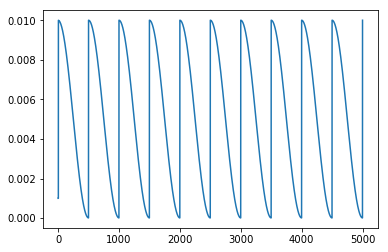

In [21]:
scheduler = SGDRScheduler(optimizer, min_lr=1e-5, max_lr=1e-2, cycle_length=500)
lrs = []
for i in range(5000):
    scheduler.step()
    lrs.append(optimizer.param_groups[0]['lr'])
plt.plot(lrs);

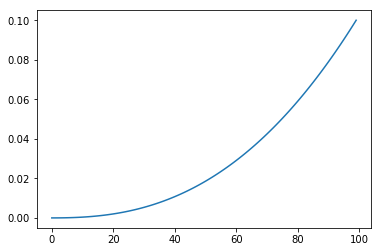

In [22]:
scheduler = LRFinderScheduler(optimizer, gamma=2.5)
lrs = []
for i in range(100):
    scheduler.step()
    lrs.append(scheduler.lr)
plt.plot(lrs);